Le but de ce notebook est de réaliser du feature engineering afin d’évaluer si cela améliore les performances du modèle Random Forest,et la regression logistique notamment en introduisant des variables comme la pente, l'asymétrie et la fréquence de courbure.



In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report,make_scorer, precision_score, recall_score, f1_score, accuracy_score
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Pour lire le dataset

In [ ]:

data = pd.read_csv(r"../../Data/Cleaned_Dataframe.csv",sep=';')
display(data.head())

ModuleNotFoundError: No module named 'codecarbon'

# Encodage des variables

In [20]:
data["ACOUPHENES"]=data["ACOUPHENES"].map({"Oui":1,"Non":0})
data["ANTECEDENT_FAMILIAUX"]=data["ANTECEDENT_FAMILIAUX"].map({"Oui":1,"Non":0})
data["DIABETE"]=data["DIABETE"].map({"Oui":1,"Non":0})
data["EXPOSITION"]=data["EXPOSITION"].map({"Oui":1,"Non":0})
data["SEXE"]=data["SEXE"].map({"H":1,"F":0})

display(data.head(5))
display(data.tail(5))

,ID_CLIENT,ANTECEDENT_FAMILIAUX,ACOUPHENES,DIABETE,EXPOSITION,AGE,SEXE,FREQ_250_D_THR,FREQ_250_G_THR,FREQ_250_D_UCL,...,FREQ_2000_D_UCL,FREQ_2000_G_UCL,FREQ_4000_D_THR,FREQ_4000_G_THR,FREQ_4000_D_UCL,FREQ_4000_G_UCL,FREQ_8000_D_THR,FREQ_8000_G_THR,FREQ_8000_D_UCL,FREQ_8000_G_UCL
0,1,0.0,1,0.0,1.0,55.0,1.0,20.0,30.0,100.0,...,110,110,60,65,110,110,NaN,NaN,NaN,NaN
1,105,0.0,1,0.0,0.0,77.0,0.0,20.0,35.0,100.0,...,110,110,60,65,115,120,60.0,60.0,NaN,NaN
2,162,0.0,1,0.0,0.0,63.0,0.0,25.0,30.0,85.0,...,105,105,105,100,120,115,105.0,105.0,NaN,NaN
3,345,0.0,1,0.0,1.0,65.0,0.0,25.0,15.0,95.0,...,100,95,15,10,90,100,40.0,35.0,90.0,85.0
4,1120,0.0,1,0.0,1.0,0.0,0.0,15.0,10.0,83.0,...,89,87,30,35,90,94,90.0,95.0,NaN,NaN


,ID_CLIENT,ANTECEDENT_FAMILIAUX,ACOUPHENES,DIABETE,EXPOSITION,AGE,SEXE,FREQ_250_D_THR,FREQ_250_G_THR,FREQ_250_D_UCL,...,FREQ_2000_D_UCL,FREQ_2000_G_UCL,FREQ_4000_D_THR,FREQ_4000_G_THR,FREQ_4000_D_UCL,FREQ_4000_G_UCL,FREQ_8000_D_THR,FREQ_8000_G_THR,FREQ_8000_D_UCL,FREQ_8000_G_UCL
62270,A7406761,1.0,0,0.0,0.0,85.0,0.0,40.0,50.0,75.0,...,85,85,65,55,95,90,50.0,60.0,85.0,95.0
62271,A7406762,1.0,1,0.0,1.0,84.0,1.0,35.0,30.0,90.0,...,110,115,105,110,0,0,95.0,95.0,NaN,NaN
62272,A7406764,1.0,0,1.0,1.0,74.0,1.0,20.0,35.0,80.0,...,105,100,85,80,110,105,65.0,70.0,95.0,95.0
62273,A7406796,0.0,1,1.0,1.0,74.0,1.0,70.0,55.0,100.0,...,95,85,85,90,100,110,90.0,95.0,NaN,NaN
62274,DUMFR663,0.0,1,1.0,0.0,71.0,1.0,15.0,45.0,NaN,...,100,110,55,85,105,120,80.0,90.0,NaN,NaN


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62275 entries, 0 to 62274
Data columns (total 31 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID_CLIENT             62275 non-null  object 
 1   ANTECEDENT_FAMILIAUX  59620 non-null  float64
 2   ACOUPHENES            62275 non-null  int64  
 3   DIABETE               59741 non-null  float64
 4   EXPOSITION            60812 non-null  float64
 5   AGE                   62275 non-null  float64
 6   SEXE                  62256 non-null  float64
 7   FREQ_250_D_THR        62142 non-null  float64
 8   FREQ_250_G_THR        62121 non-null  float64
 9   FREQ_250_D_UCL        40699 non-null  float64
 10  FREQ_250_G_UCL        40582 non-null  float64
 11  FREQ_500_D_THR        62275 non-null  int64  
 12  FREQ_500_G_THR        62275 non-null  int64  
 13  FREQ_500_D_UCL        62275 non-null  int64  
 14  FREQ_500_G_UCL        62275 non-null  int64  
 15  FREQ_1000_D_THR    

# feature engineering: asymetrie et pente

In [22]:
#****************************************************************Asymetrie*****************************************************************************
# pour THR
data['diff_250_THR']= abs(data['FREQ_250_D_THR']-data['FREQ_250_G_THR'])
data['diff_500_THR']= abs(data['FREQ_500_D_THR']-data['FREQ_500_G_THR'])
data['diff_1000_THR']= abs(data['FREQ_1000_D_THR']-data['FREQ_1000_G_THR'])
data['diff_2000_THR']= abs(data['FREQ_2000_D_THR']-data['FREQ_2000_G_THR'])
data['diff_4000_THR']= abs(data['FREQ_4000_D_THR']-data['FREQ_4000_G_THR'])
data['diff_8000_THR']= abs(data['FREQ_8000_D_THR']-data['FREQ_8000_G_THR'])


# pour UCL
data['diff_250_UCL']= abs(data['FREQ_250_D_UCL']-data['FREQ_250_G_UCL'])
data['diff_500_UCL']= abs(data['FREQ_500_D_UCL']-data['FREQ_500_G_UCL'])
data['diff_1000_UCL']= abs(data['FREQ_1000_D_UCL']-data['FREQ_1000_G_UCL'])
data['diff_2000_UCL']= abs(data['FREQ_2000_D_UCL']-data['FREQ_2000_G_UCL'])
data['diff_4000_UCL']= abs(data['FREQ_500_D_UCL']-data['FREQ_500_G_UCL'])
data['diff_8000_UCL']= abs(data['FREQ_8000_D_UCL']-data['FREQ_8000_G_UCL'])

# ************************************************************************* Pente *******************************************************************************

# pour THR
data["slope_THR_droite"] = data["FREQ_4000_D_THR"] - data["FREQ_500_D_THR"]
data["slope_THR_gauche"] = data["FREQ_4000_G_THR"] - data["FREQ_500_G_THR"]
data["slope_THR_moyenne"] = (data["slope_THR_droite"] + data["slope_THR_gauche"]) / 2

# pour UCL

data["slope_UCL_droite"] = data["FREQ_4000_D_UCL"] - data["FREQ_500_D_UCL"]
data["slope_UCL_gauche"] = data["FREQ_4000_G_UCL"] - data["FREQ_500_G_UCL"]
data["slope_UCL_moyenne"] = (data["slope_UCL_droite"] + data["slope_UCL_gauche"]) / 2



Analyse des tests THR

In [23]:
data_THR = data.drop(columns=data.columns[data.columns.str.contains("UCL")])
data_THR=data_THR.dropna()
display(data_THR.isna().sum())
display(len(data_THR))

ID_CLIENT               0
ANTECEDENT_FAMILIAUX    0
ACOUPHENES              0
DIABETE                 0
EXPOSITION              0
AGE                     0
SEXE                    0
FREQ_250_D_THR          0
FREQ_250_G_THR          0
FREQ_500_D_THR          0
FREQ_500_G_THR          0
FREQ_1000_D_THR         0
FREQ_1000_G_THR         0
FREQ_2000_D_THR         0
FREQ_2000_G_THR         0
FREQ_4000_D_THR         0
FREQ_4000_G_THR         0
FREQ_8000_D_THR         0
FREQ_8000_G_THR         0
diff_250_THR            0
diff_500_THR            0
diff_1000_THR           0
diff_2000_THR           0
diff_4000_THR           0
diff_8000_THR           0
slope_THR_droite        0
slope_THR_gauche        0
slope_THR_moyenne       0
dtype: int64

54441

# standardisons les données pour qu'elles aient la même échelle

In [24]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


X,Y = data_THR.select_dtypes(include="number").drop(columns="ACOUPHENES"), data_THR["ACOUPHENES"]

scalar = StandardScaler()
X = scalar.fit_transform(X)

# cross validation random forest

In [25]:

# modèle

clf = RandomForestClassifier(random_state=42)


Y_pred = cross_val_predict(clf, X,Y,cv=5)

# Génère les résultats dans un dictionnaire
report = classification_report(Y, Y_pred, output_dict=True)

# Transforme le dictionnaire en DataFrame lisible
df_report = pd.DataFrame(report).T  # .T = transpose, pour lignes = classes

# Affiche correctement le tableau
print(df_report.round(3))

[codecarbon INFO @ 10:17:35] Energy consumed for RAM : 0.000025 kWh. RAM Power : 5.898098945617677 W
[codecarbon INFO @ 10:17:35] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:17:35] 0.000202 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:17:50] Energy consumed for RAM : 0.000049 kWh. RAM Power : 5.898098945617677 W
[codecarbon INFO @ 10:17:50] Energy consumed for all CPUs : 0.000355 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:17:50] 0.000404 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:18:05] Energy consumed for RAM : 0.000074 kWh. RAM Power : 5.898098945617677 W
[codecarbon INFO @ 10:18:05] Energy consumed for all CPUs : 0.000532 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:18:05] 0.000606 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:18:20] Energy consumed for RAM : 0.000098 kWh. RAM Power : 5.898098945617677 W
[codecarbon INFO @ 10:18:20] Energy consumed for a

              precision  recall  f1-score    support
0                 0.590   0.700     0.640  29550.000
1                 0.542   0.422     0.475  24891.000
accuracy          0.573   0.573     0.573      0.573
macro avg         0.566   0.561     0.557  54441.000
weighted avg      0.568   0.573     0.565  54441.000


Le modèle Random Forest présente une performance globalement moyenne (accuracy = 57,3 %), avec un fort déséquilibre entre les deux classes : il détecte assez bien les individus sans acouphènes (rappel = 70 %, F1 = 0.64), mais peine à identifier correctement ceux avec acouphènes (rappel = 42 %, F1 = 0.475). Cela montre que le modèle a tendance à prédire majoritairement l'absence d’acouphènes

# cross validation pour la regression logistique

              precision  recall  f1-score    support
0                 0.596   0.738     0.659  29550.000
1                 0.566   0.405     0.472  24891.000
accuracy          0.586   0.586     0.586      0.586
macro avg         0.581   0.572     0.566  54441.000
weighted avg      0.582   0.586     0.574  54441.000


C:\Users\wendy\AppData\Local\Temp\ipykernel_28240\1713812531.py:22: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\wendy\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


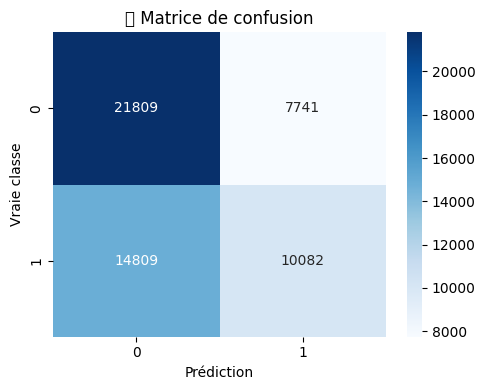

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report,make_scorer, precision_score, recall_score, f1_score, accuracy_score

logis = LogisticRegression()
Y_predLogis = cross_val_predict(logis, X,Y,cv=5)

# Génère les résultats dans un dictionnaire
report = classification_report(Y, Y_predLogis, output_dict=True)

# Transforme le dictionnaire en DataFrame lisible
df_report = pd.DataFrame(report).T  # .T = transpose, pour lignes = classes

# Affiche correctement le tableau
print(df_report.round(3))

cm = confusion_matrix(Y, Y_predLogis)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédiction")
plt.ylabel("Vraie classe")
plt.title("🧩 Matrice de confusion")
plt.tight_layout()
plt.show()



Le modèle de régression logistique atteint une accuracy globale de 58,6 %, soit légèrement meilleure que celle du Random Forest, mais présente le même déséquilibre de performance entre les classes. Il identifie bien les individus sans acouphènes (rappel = 73,8 %, F1 = 0.659), mais a des difficultés notables à détecter ceux avec acouphènes, avec un rappel très faible (40,5 %) et un F1-score de 0.472. Ce résultat confirme que le modèle penche fortement vers la classe majoritaire et reste peu fiable pour la classe cliniquement intéressante. Malgré une précision un peu meilleure que le Random Forest sur la classe 1, la régression logistique ne parvient pas non plus à corriger le biais de classification

# Ajout de features : fréquence de coupure

La fréquence de courbure correspond à la première fréquence (dans l’ordre croissant) à partir de laquelle la pente de l’audiogramme devient anormalement raide.

Concrètement, nous calculons la pente entre chaque paire de fréquences adjacentes (en dB/octave).
Une pente est considérée comme anormalement raide si elle dépasse 15 dB/octave.

In [27]:

freq_cols_d = ['FREQ_250_D_THR', 'FREQ_500_D_THR', 'FREQ_1000_D_THR', 
                   'FREQ_2000_D_THR', 'FREQ_4000_D_THR', 'FREQ_8000_D_THR']
freq_cols_g = ['FREQ_250_G_THR', 'FREQ_500_G_THR', 'FREQ_1000_G_THR', 
                   'FREQ_2000_G_THR', 'FREQ_4000_G_THR', 'FREQ_8000_G_THR']
    
frequencies = [250, 500, 1000, 2000, 4000, 8000]


def find_cutoff_frequency(row, ear_cols):
        """Trouve la fréquence de coupure basée sur la pente anormale"""
        thresholds = [row[col] for col in ear_cols]
        
        # Chercher la première pente > 15 dB/octave (anormale)
        for i in range(len(thresholds) - 1):
            # Calcul de la pente entre deux fréquences adjacentes
            freq_ratio = frequencies[i+1] / frequencies[i]  # ratio d'octave
            octaves = np.log2(freq_ratio)
            slope = (thresholds[i+1] - thresholds[i]) / octaves
            
            if slope > 15:  # Pente anormalement raide
                return frequencies[i]
        
        return 8000  # Si pas de pente anormale détectée

In [28]:
# application de la fonction: 
data_THR['cutoff_freq_droite'] = data_THR.apply(
        lambda row: find_cutoff_frequency(row, freq_cols_d), axis=1)
data_THR['cutoff_freq_gauche'] = data_THR.apply(
        lambda row: find_cutoff_frequency(row, freq_cols_g), axis=1)
data_THR['cutoff_freq_asymmetry'] = abs(
data_THR['cutoff_freq_droite'] - data_THR['cutoff_freq_gauche'])

[codecarbon INFO @ 10:18:36] Energy consumed for RAM : 0.000123 kWh. RAM Power : 5.898098945617677 W
[codecarbon INFO @ 10:18:36] Energy consumed for all CPUs : 0.000887 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:18:36] 0.001010 kWh of electricity used since the beginning.


In [29]:
data_THR.columns
data_THR.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54441 entries, 1 to 62274
Data columns (total 31 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID_CLIENT              54441 non-null  object 
 1   ANTECEDENT_FAMILIAUX   54441 non-null  float64
 2   ACOUPHENES             54441 non-null  int64  
 3   DIABETE                54441 non-null  float64
 4   EXPOSITION             54441 non-null  float64
 5   AGE                    54441 non-null  float64
 6   SEXE                   54441 non-null  float64
 7   FREQ_250_D_THR         54441 non-null  float64
 8   FREQ_250_G_THR         54441 non-null  float64
 9   FREQ_500_D_THR         54441 non-null  int64  
 10  FREQ_500_G_THR         54441 non-null  int64  
 11  FREQ_1000_D_THR        54441 non-null  int64  
 12  FREQ_1000_G_THR        54441 non-null  int64  
 13  FREQ_2000_D_THR        54441 non-null  int64  
 14  FREQ_2000_G_THR        54441 non-null  int64  
 15  FREQ_40

# cross validation avec l'ajout de la fréquence de coupure

In [30]:
X_new,Y_new = data_THR.select_dtypes(include="number").drop(columns="ACOUPHENES"), data_THR["ACOUPHENES"]

scalar = StandardScaler()
X_new = scalar.fit_transform(X_new)

In [31]:

# modèle
clf = RandomForestClassifier(random_state=42)


Y_pred = cross_val_predict(clf, X_new,Y_new,cv=5)

# Génère les résultats dans un dictionnaire
report = classification_report(Y, Y_pred, output_dict=True)

# Transforme le dictionnaire en DataFrame lisible
df_report = pd.DataFrame(report).T  # .T = transpose, pour lignes = classes


# Affiche correctement le tableau
print(df_report.round(3))

[codecarbon INFO @ 10:18:51] Energy consumed for RAM : 0.000147 kWh. RAM Power : 5.898098945617677 W
[codecarbon INFO @ 10:18:51] Energy consumed for all CPUs : 0.001063 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:18:51] 0.001210 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:19:06] Energy consumed for RAM : 0.000172 kWh. RAM Power : 5.898098945617677 W
[codecarbon INFO @ 10:19:06] Energy consumed for all CPUs : 0.001240 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:19:06] 0.001412 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:19:21] Energy consumed for RAM : 0.000196 kWh. RAM Power : 5.898098945617677 W
[codecarbon INFO @ 10:19:21] Energy consumed for all CPUs : 0.001417 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:19:21] 0.001614 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:19:21] 0.000753 g.CO2eq/s mean an estimation of 23.734550412512178 kg.CO2eq/year
[codecarbon INFO @ 10:19:36] Energy consumed for

              precision  recall  f1-score    support
0                 0.589   0.704     0.641  29550.000
1                 0.542   0.416     0.471  24891.000
accuracy          0.572   0.572     0.572      0.572
macro avg         0.565   0.560     0.556  54441.000
weighted avg      0.567   0.572     0.563  54441.000


Malgré l’ajout de la fréquence de courbure comme variable explicative, les performances du modèle Random Forest sont restées inchangées.
Cela suggère que cette caractéristique, bien qu’intuitivement pertinente sur le plan audiologique, n’apporte pas de gain discriminant significatif dans le cadre de notre classification actuelle (présence ou absence d’acouphènes).

              precision  recall  f1-score    support
0                 0.596   0.738     0.659  29550.000
1                 0.566   0.405     0.472  24891.000
accuracy          0.586   0.586     0.586      0.586
macro avg         0.581   0.572     0.566  54441.000
weighted avg      0.582   0.586     0.574  54441.000


C:\Users\wendy\AppData\Local\Temp\ipykernel_28240\1683617273.py:22: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\wendy\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


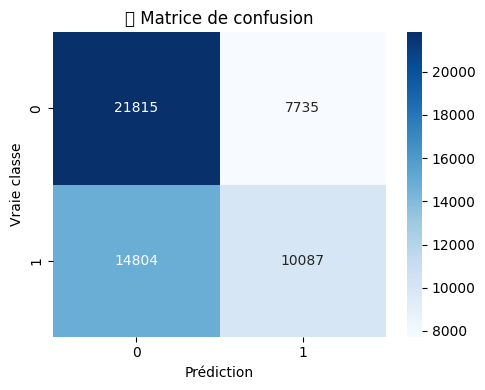

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report,make_scorer, precision_score, recall_score, f1_score, accuracy_score

logis = LogisticRegression()
Y_predLogis = cross_val_predict(logis, X_new,Y_new,cv=5)

# Génère les résultats dans un dictionnaire
report = classification_report(Y_new, Y_predLogis, output_dict=True)

# Transforme le dictionnaire en DataFrame lisible
df_report = pd.DataFrame(report).T  # .T = transpose, pour lignes = classes

# Affiche correctement le tableau
print(df_report.round(3))

cm = confusion_matrix(Y_new, Y_predLogis)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédiction")
plt.ylabel("Vraie classe")
plt.title("🧩 Matrice de confusion")
plt.tight_layout()
plt.show()



Le même constat se fait sur la regression logistique

# catégorisons les audiogrammes selons les classes

In [33]:
def classer_audiogramme(row):
    # Moyennes sur les basses et hautes fréquences
    basses_freqs = ['FREQ_250_D_THR', 'FREQ_500_D_THR', 'FREQ_1000_D_THR']
    hautes_freqs = ['FREQ_2000_D_THR', 'FREQ_4000_D_THR', 'FREQ_8000_D_THR']
    
    seuils_basses = row[basses_freqs].mean()
    seuils_hautes = row[hautes_freqs].mean()

    # Pente entre 1000 Hz et 8000 Hz (environ 3 octaves)
    pente = (row['FREQ_8000_D_THR'] - row['FREQ_1000_D_THR']) / 3

    # Classification
    if seuils_basses <= 10 and seuils_hautes <= 20:
        return 'older-normal'
    elif seuils_basses <= 10 and 10 <= seuils_hautes <= 25:
        return 'pre-metabolic'
    elif 10 <= seuils_basses <= 40 and 30 <= seuils_hautes <= 60 and 10 <= pente <= 20:
        return 'metabolic'
    elif seuils_basses <= 10 and 40 <= seuils_hautes <= 70 and pente > 20:
        return 'sensory'
    elif 10 <= seuils_basses <= 40 and 40 <= seuils_hautes <= 70 and pente > 20:
        return 'metabolic + sensory'
    else:
        return 'inclassable'


Types d’audiogrammes classifiés :
Audiogrammes "normaux pour l’âge" ("older-normal")
→ Seuils ≤ 10 dB HL de 0,25 à 1,0 kHz
→ Et de 0 à 20 dB HL aux fréquences plus élevées.

Audiogrammes "pré-métaboliques" ("pre-metabolic")
→ Seuils ≤ 10 dB HL de 0,25 à 1,0 kHz
→ Et de 10 à 25 dB HL aux fréquences plus élevées.

Audiogrammes "métaboliques" (légers à sévères)
→ Perte auditive relativement plate dans les basses fréquences, entre 10 et 40 dB HL
→ Et perte progressive dans les hautes fréquences entre 30 et 60 dB HL
→ Avec une pente de 10 à 20 dB par octave.

Audiogrammes "sensoriels"
→ Seuils normaux dans les basses fréquences (≤10 dB HL)
→ Avec une augmentation abrupte des seuils dans les hautes fréquences, formant une encoche ou un plateau entre 40 et 70 dB HL
→ Avec une pente de plus de 20 dB par octave.

Audiogrammes "métaboliques + sensoriels"
→ Caractéristiques métaboliques dans les basses fréquences (perte plate de 10 à 40 dB HL)
→ Et caractéristiques sensorielles dans les hautes fréquences (perte abrupte, pente > 20 dB/octave).



In [34]:
data_THR['CLASSE_AUDIOGRAMME'] = data_THR.apply(classer_audiogramme, axis=1)


[codecarbon INFO @ 10:20:36] Energy consumed for RAM : 0.000319 kWh. RAM Power : 5.898098945617677 W
[codecarbon INFO @ 10:20:36] Energy consumed for all CPUs : 0.002303 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:20:36] 0.002622 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:20:51] Energy consumed for RAM : 0.000343 kWh. RAM Power : 5.898098945617677 W
[codecarbon INFO @ 10:20:51] Energy consumed for all CPUs : 0.002482 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:20:51] 0.002826 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:21:06] Energy consumed for RAM : 0.000368 kWh. RAM Power : 5.898098945617677 W
[codecarbon INFO @ 10:21:06] Energy consumed for all CPUs : 0.002658 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:21:06] 0.003026 kWh of electricity used since the beginning.


In [35]:
# separons maintenant les datasets
data_normal =data_THR[data_THR["CLASSE_AUDIOGRAMME"] == "older-normal"]
data_pre_metabolic = data_THR[data_THR["CLASSE_AUDIOGRAMME"] == "pre-metabolic"]
data_metabolic =data_THR[data_THR["CLASSE_AUDIOGRAMME"] == "metabolic"]
data_sensory =data_THR[data_THR["CLASSE_AUDIOGRAMME"] == "sensory"]
data_metabolic_sensory =data_THR[data_THR["CLASSE_AUDIOGRAMME"] == "metabolic + sensory"]

# Type normal

              precision  recall  f1-score  support
0                 0.611   0.703     0.654   145.00
1                 0.656   0.558     0.603   147.00
accuracy          0.630   0.630     0.630     0.63
macro avg         0.633   0.631     0.628   292.00
weighted avg      0.634   0.630     0.628   292.00
              precision  recall  f1-score  support
0                 0.589   0.614     0.601  145.000
1                 0.603   0.578     0.590  147.000
accuracy          0.596   0.596     0.596    0.596
macro avg         0.596   0.596     0.596  292.000
weighted avg      0.596   0.596     0.596  292.000


C:\Users\wendy\AppData\Local\Temp\ipykernel_28240\2935673186.py:45: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\wendy\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


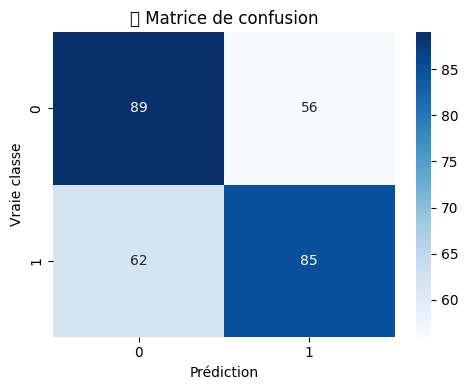

In [36]:
# analysons maintenant pour le older-normal
X,Y = data_normal.select_dtypes(include="number").drop(columns="ACOUPHENES"), data_normal["ACOUPHENES"]

scalar = StandardScaler()
X = scalar.fit_transform(X)

# ***********************************************************randomforest

# modèle
clf = RandomForestClassifier(random_state=42)


Y_pred = cross_val_predict(clf, X,Y,cv=5)

# Génère les résultats dans un dictionnaire
report = classification_report(Y, Y_pred, output_dict=True)

# Transforme le dictionnaire en DataFrame lisible
df_report = pd.DataFrame(report).T  # .T = transpose, pour lignes = classes


# Affiche correctement le tableau
print(df_report.round(3))

# **************************************************regressionlogistique

logis = LogisticRegression()
Y_predLogis = cross_val_predict(logis, X,Y,cv=5)

# Génère les résultats dans un dictionnaire
report = classification_report(Y, Y_predLogis, output_dict=True)

# Transforme le dictionnaire en DataFrame lisible
df_report = pd.DataFrame(report).T  # .T = transpose, pour lignes = classes

# Affiche correctement le tableau
print(df_report.round(3))

cm = confusion_matrix(Y, Y_predLogis)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédiction")
plt.ylabel("Vraie classe")
plt.title("🧩 Matrice de confusion")
plt.tight_layout()
plt.show()




 en étudiant les personnes en fonction de sa classe on se rend compte que les performances du modèle se sont améliorés pour le type normal, l'accuracy est passé de 0.5 à 0.6 environ et le recall de la classe acouphène s'est amélioré: on est passé de 0.4 à 0.6 environ

# Type prémetabolic

[codecarbon INFO @ 10:21:21] Energy consumed for RAM : 0.000392 kWh. RAM Power : 5.898098945617677 W
[codecarbon INFO @ 10:21:21] Energy consumed for all CPUs : 0.002832 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:21:21] 0.003224 kWh of electricity used since the beginning.
[codecarbon INFO @ 10:21:21] 0.000751 g.CO2eq/s mean an estimation of 23.682029255567684 kg.CO2eq/year


              precision  recall  f1-score  support
0                 0.471   0.432     0.451   37.000
1                 0.500   0.538     0.519   39.000
accuracy          0.487   0.487     0.487    0.487
macro avg         0.485   0.485     0.485   76.000
weighted avg      0.486   0.487     0.486   76.000
              precision  recall  f1-score  support
0                 0.351   0.351     0.351   37.000
1                 0.385   0.385     0.385   39.000
accuracy          0.368   0.368     0.368    0.368
macro avg         0.368   0.368     0.368   76.000
weighted avg      0.368   0.368     0.368   76.000


C:\Users\wendy\AppData\Local\Temp\ipykernel_28240\233929903.py:45: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\wendy\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


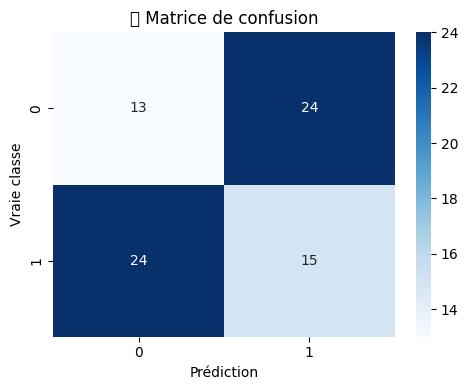

In [37]:
# analysons maintenant pour le older-normal
X,Y = data_pre_metabolic.select_dtypes(include="number").drop(columns="ACOUPHENES"), data_pre_metabolic["ACOUPHENES"]

scalar = StandardScaler()
X = scalar.fit_transform(X)

# ***********************************************************randomforest

# modèle
clf = RandomForestClassifier(random_state=42)


Y_pred = cross_val_predict(clf, X,Y,cv=5)

# Génère les résultats dans un dictionnaire
report = classification_report(Y, Y_pred, output_dict=True)

# Transforme le dictionnaire en DataFrame lisible
df_report = pd.DataFrame(report).T  # .T = transpose, pour lignes = classes


# Affiche correctement le tableau
print(df_report.round(3))

# **************************************************regressionlogistique

logis = LogisticRegression()
Y_predLogis = cross_val_predict(logis, X,Y,cv=5)

# Génère les résultats dans un dictionnaire
report = classification_report(Y, Y_predLogis, output_dict=True)

# Transforme le dictionnaire en DataFrame lisible
df_report = pd.DataFrame(report).T  # .T = transpose, pour lignes = classes

# Affiche correctement le tableau
print(df_report.round(3))

cm = confusion_matrix(Y, Y_predLogis)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédiction")
plt.ylabel("Vraie classe")
plt.title("🧩 Matrice de confusion")
plt.tight_layout()
plt.show()




# Type metabolic

[codecarbon INFO @ 10:21:36] Energy consumed for RAM : 0.000416 kWh. RAM Power : 5.898098945617677 W
[codecarbon INFO @ 10:21:36] Energy consumed for all CPUs : 0.003010 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 10:21:36] 0.003426 kWh of electricity used since the beginning.


              precision  recall  f1-score    support
0                 0.559   0.597     0.577   7272.000
1                 0.549   0.510     0.529   6999.000
accuracy          0.554   0.554     0.554      0.554
macro avg         0.554   0.553     0.553  14271.000
weighted avg      0.554   0.554     0.553  14271.000
              precision  recall  f1-score    support
0                 0.578   0.624     0.600   7272.000
1                 0.574   0.525     0.549   6999.000
accuracy          0.576   0.576     0.576      0.576
macro avg         0.576   0.575     0.574  14271.000
weighted avg      0.576   0.576     0.575  14271.000


C:\Users\wendy\AppData\Local\Temp\ipykernel_28240\1465511514.py:45: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\wendy\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


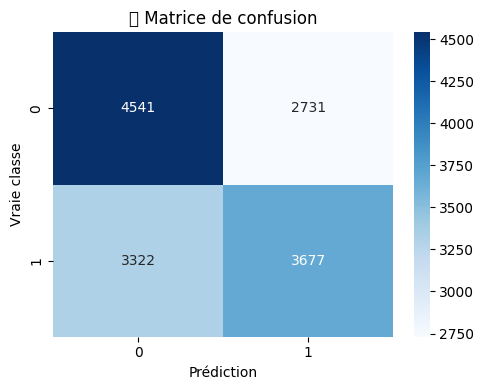

In [38]:
# analysons maintenant pour le older-normal
X,Y = data_metabolic.select_dtypes(include="number").drop(columns="ACOUPHENES"), data_metabolic["ACOUPHENES"]

scalar = StandardScaler()
X = scalar.fit_transform(X)

# ***********************************************************randomforest

# modèle
clf = RandomForestClassifier(random_state=42)


Y_pred = cross_val_predict(clf, X,Y,cv=5)

# Génère les résultats dans un dictionnaire
report = classification_report(Y, Y_pred, output_dict=True)

# Transforme le dictionnaire en DataFrame lisible
df_report = pd.DataFrame(report).T  # .T = transpose, pour lignes = classes


# Affiche correctement le tableau
print(df_report.round(3))

# **************************************************regressionlogistique

logis = LogisticRegression()
Y_predLogis = cross_val_predict(logis, X,Y,cv=5)

# Génère les résultats dans un dictionnaire
report = classification_report(Y, Y_predLogis, output_dict=True)

# Transforme le dictionnaire en DataFrame lisible
df_report = pd.DataFrame(report).T  # .T = transpose, pour lignes = classes

# Affiche correctement le tableau
print(df_report.round(3))

cm = confusion_matrix(Y, Y_predLogis)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédiction")
plt.ylabel("Vraie classe")
plt.title("🧩 Matrice de confusion")
plt.tight_layout()
plt.show()




# Type sensority

              precision  recall  f1-score  support
0                 0.429   0.422     0.425   64.000
1                 0.464   0.471     0.467   68.000
accuracy          0.447   0.447     0.447    0.447
macro avg         0.446   0.446     0.446  132.000
weighted avg      0.447   0.447     0.447  132.000
              precision  recall  f1-score  support
0                 0.413   0.406     0.409   64.000
1                 0.449   0.456     0.453   68.000
accuracy          0.432   0.432     0.432    0.432
macro avg         0.431   0.431     0.431  132.000
weighted avg      0.432   0.432     0.432  132.000


C:\Users\wendy\AppData\Local\Temp\ipykernel_28240\1119678963.py:45: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\wendy\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


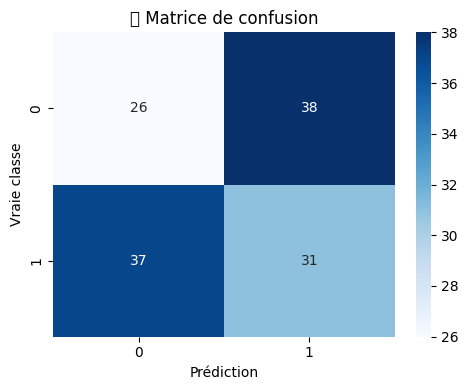

In [39]:
# analysons maintenant pour le older-normal
X,Y = data_sensory.select_dtypes(include="number").drop(columns="ACOUPHENES"), data_sensory["ACOUPHENES"]

scalar = StandardScaler()
X = scalar.fit_transform(X)

# ***********************************************************randomforest

# modèle
clf = RandomForestClassifier(random_state=42)


Y_pred = cross_val_predict(clf, X,Y,cv=5)

# Génère les résultats dans un dictionnaire
report = classification_report(Y, Y_pred, output_dict=True)

# Transforme le dictionnaire en DataFrame lisible
df_report = pd.DataFrame(report).T  # .T = transpose, pour lignes = classes


# Affiche correctement le tableau
print(df_report.round(3))

# **************************************************regressionlogistique

logis = LogisticRegression()
Y_predLogis = cross_val_predict(logis, X,Y,cv=5)

# Génère les résultats dans un dictionnaire
report = classification_report(Y, Y_predLogis, output_dict=True)

# Transforme le dictionnaire en DataFrame lisible
df_report = pd.DataFrame(report).T  # .T = transpose, pour lignes = classes

# Affiche correctement le tableau
print(df_report.round(3))

cm = confusion_matrix(Y, Y_predLogis)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédiction")
plt.ylabel("Vraie classe")
plt.title("🧩 Matrice de confusion")
plt.tight_layout()
plt.show()




# Type metabolic et sensority

              precision  recall  f1-score   support
0                 0.551   0.588     0.569   769.000
1                 0.535   0.497     0.515   733.000
accuracy          0.543   0.543     0.543     0.543
macro avg         0.543   0.542     0.542  1502.000
weighted avg      0.543   0.543     0.542  1502.000
              precision  recall  f1-score   support
0                 0.573   0.599     0.586   769.000
1                 0.559   0.532     0.545   733.000
accuracy          0.567   0.567     0.567     0.567
macro avg         0.566   0.566     0.566  1502.000
weighted avg      0.566   0.567     0.566  1502.000


C:\Users\wendy\AppData\Local\Temp\ipykernel_28240\2873496740.py:45: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\wendy\miniconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


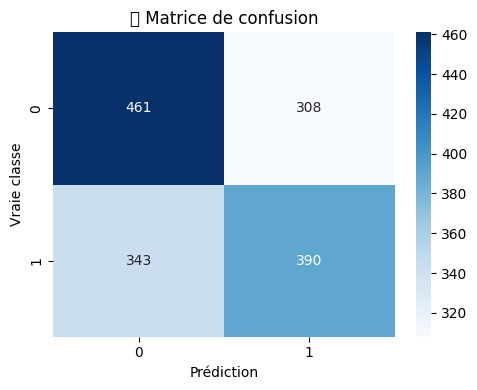

[codecarbon INFO @ 10:21:51] Energy consumed for RAM : 0.000441 kWh. RAM Power : 5.898098945617677 W


[codecarbon INFO @ 10:21:51] Energy consumed for all CPUs : 0.003187 kWh. Total CPU Power : 42.5 W


In [40]:
# analysons maintenant pour le older-normal
X,Y = data_metabolic_sensory.select_dtypes(include="number").drop(columns="ACOUPHENES"), data_metabolic_sensory["ACOUPHENES"]

scalar = StandardScaler()
X = scalar.fit_transform(X)

# ***********************************************************randomforest

# modèle
clf = RandomForestClassifier(random_state=42)


Y_pred = cross_val_predict(clf, X,Y,cv=5)

# Génère les résultats dans un dictionnaire
report = classification_report(Y, Y_pred, output_dict=True)

# Transforme le dictionnaire en DataFrame lisible
df_report = pd.DataFrame(report).T  # .T = transpose, pour lignes = classes


# Affiche correctement le tableau
print(df_report.round(3))

# **************************************************regressionlogistique

logis = LogisticRegression()
Y_predLogis = cross_val_predict(logis, X,Y,cv=5)

# Génère les résultats dans un dictionnaire
report = classification_report(Y, Y_predLogis, output_dict=True)

# Transforme le dictionnaire en DataFrame lisible
df_report = pd.DataFrame(report).T  # .T = transpose, pour lignes = classes

# Affiche correctement le tableau
print(df_report.round(3))

cm = confusion_matrix(Y, Y_predLogis)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédiction")
plt.ylabel("Vraie classe")
plt.title("🧩 Matrice de confusion")
plt.tight_layout()
plt.show()




on constate donc que pour les autres types d'audiogrammes, notamment les pre_metabolic les performances se sont dégradés encore plus avec la regression logistique avec des metriques très faibles (0.3) pour le metabolic ils se sont légèrement amélioré et tournent autour du hazard 0.5, pour le sensority, on a vu que le sensority, les performance ont chuté vers 0.4 pour l'accuracy, et enfin pour le metabolic et sensority on remonte aux alantour de 0.5

en conclusion, on se rend compte que les meilleures prédictions sont celles pour les personnes normales, sans perte auditives, et on observe aussi que pour la pertes auditives, pour les pertes de type premetabolic et sensority on est en dessous du hazard, le modèle n'arrive vraiment pas à trouver à généraliser à cause probablement des faibles échantillons